In [6]:
import numpy as np
from scipy.integrate import odeint
from scipy import stats
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import os
import collections
import functools
import seaborn as sns
from scipy.interpolate import interp1d
import matplotlib as mpl

sns.set_context('poster')
sns.set_style('white')
sns.set_palette('Paired', 25)
colors = sns.color_palette('Paired', 25)

pgf_with_custom_preamble = {
    "text.usetex": False,    # use inline math for ticks
    "pgf.rcfonts": False,   # don't setup fonts from rc parameters
}

def figsize(scale, height_ratio=1.0):
    fig_width_pt = 344.43306                        # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = height_ratio*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "sans-serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 10,               # LaTeX default is 10pt font.
    "font.size": 10,
    "legend.fontsize": 8,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "figure.figsize": figsize(0.9),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }

sns.set_style('ticks')
sns.set_context('poster')
sns.set_palette('dark', 40)

colors = sns.color_palette('dark', 40)

mpl.rcParams.update(pgf_with_latex)

# I make my own newfig and savefig functions
def newfig(width):
    plt.clf()
    fig = plt.figure(figsize=figsize(width))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename):
    plt.savefig('{}.pgf'.format(filename))
    plt.savefig('{}.pdf'.format(filename))

%matplotlib inline

# No water

In [149]:
states_no_water = collections.defaultdict(dict)
nb_no_water = collections.defaultdict(dict)
t2name = {'t0': 'D', 't1': 'A', 't3': 'C', 't4': 'E', 't5': 'W'}
path = 'scan_p_1000/no_water/'
for f in os.listdir(path):
    if f.startswith('states_'):
        p = f.split('_')[3]
        t = t2name[f.split('_')[1]]
        d = np.loadtxt(os.path.join(path, f))
        #d.dtype = [(x, np.float) for x in open(os.path.join(path, f)).readline().replace('# ', '').split()]
        if t not in states_no_water[p]:
            states_no_water[p][t] = []
        states_no_water[p][t].append(d)
    elif f.startswith('nb_'):
        p = f.split('_')[6]
        t = f.split('_')[4]
        nb_no_water[p][t] = np.loadtxt(os.path.join(path, f))
        #nb_no_water[p][t].dtype = [(x, np.float) for x in open(os.path.join(path, f)).readline().replace('# ', '').split()]

In [150]:
avg_states_no_water = collections.defaultdict(dict)
std_states_no_water = collections.defaultdict(dict)

max_states = {'A': 3, 'C': 3, 'E': 3, 'D': 3}
column = {'D': 3, 'A': 2, 'C': 1, 'E': 2}

for p, p_ts in states_no_water.items():
    for t, l in p_ts.items():
        max_length = min([len(k) for k in l])
        max_first_nonzero = 0
        tmp_l = []
        for ll in l:
            dll = np.diff(ll[:, column[t]])
            first_nonzero = np.nonzero(dll)[0][0]
            if first_nonzero > max_first_nonzero:
                max_first_nonzero = first_nonzero
        for ll in l:
            tmp_l.append(ll[first_nonzero:max_length])
        av = np.average(tmp_l, axis=0)
        avg_states_no_water[p][t] = av
        std_states_no_water[p][t] = np.std(tmp_l, axis=0)

In [151]:
def f_1(y, t):
    s0 = y[0]
    s1 = y[1]
    s2 = y[2]
    k0 = 0.0001
    k1 = 0.0001
    k2 = 0.0001
    
    ds2dt = -k2*s2
    ds1dt = -k1*s1 + k2*s2
    ds0dt = k1*s1
    
    return np.array([ds0dt, ds1dt, ds2dt])

In [152]:
cr = '0.001'
tD = avg_states_no_water[cr]['D']
tA = avg_states_no_water[cr]['A']
tC = avg_states_no_water[cr]['C']
tE = avg_states_no_water[cr]['E']

def f_de(y, t, k):
    cD   = y[0]
    cEs1 = y[1]
    cEs0 = y[2]
    kcD   = k
    kcEs1 = k
    kcEs0 = k
    
    dcDdt = -kcD*cD
    dcEs1dt = kcD*cD - kcEs1*cEs1
    dcEs0dt = kcEs1*cEs1
    
    return np.array([dcDdt, dcEs1dt, dcEs0dt])

t0 = np.linspace(500, tE[:, 0][-1], 100)

y0 = np.array([1.0, 0.0, 0.0])
y = odeint(f_de, y0, t0, args=(float(cr),))

def f_ac(y, t, k):
    a = y[0]
    c = y[1]
    dadt = -k*a**2.0
    dcdt = k*a**2.0
    
    return np.array([dadt, dcdt])

t0 = np.linspace(502, tE[:, 0][-1], 50)
y_ac = odeint(f_ac, np.array([1.0, 0.0]), t0, args=(1.40245*float(cr),))
y_ac_raw = odeint(f_ac, np.array([1.0, 0.0]), t0, args=(1.0*float(cr),))

/home/teodor/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


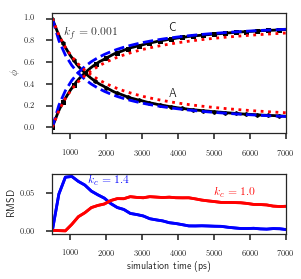

In [153]:
plt.rcParams['figure.figsize'] = figsize(0.9, height_ratio=1.5)
f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 1]})

a0.plot(tA[:, 0], tA[:, 2]/2000.0,
             linestyle='-', label='A', color='k', marker='h', markevery=300, markersize=5.0)
a0.plot(tC[:, 0], tC[:, 1]/2000.0,
             linestyle='-', label='C', color='k', marker='s', markevery=300, markersize=5.0)
a0.plot(t0, y_ac[:, 0], color='b', linestyle='--')
a0.plot(t0, y_ac[:, 1], color='b', linestyle='--')
a0.plot(t0, y_ac_raw[:, 0], color='r', linestyle=':')
a0.plot(t0, y_ac_raw[:, 1], color='r', linestyle=':')
a0.annotate(r'$k_f={}$'.format(cr), xy=(0.05, 0.8), xycoords='axes fraction', fontsize=12)
a0.annotate('A', xy=(0.5, 0.3), xycoords='axes fraction', fontsize=12)
a0.annotate('C', xy=(0.5, 0.85), xycoords='axes fraction', fontsize=12)

a0.set_ylabel(r'$\phi$')
a0.set_xlim([500, 7000])

fA = interp1d(tA[:, 0], tA[:, 2]/2000.0)
fC = interp1d(tC[:, 0], tC[:, 1]/2000.0)
a1.plot(t0, np.sqrt(np.power(fA(t0) - y_ac[:, 0], 2)), color='b')
a1.plot(t0, np.sqrt(np.power(fC(t0) - y_ac[:, 1], 2)), color='b')
a1.plot(t0, np.sqrt(np.power(fA(t0) - y_ac_raw[:, 0], 2)), color='r')
a1.plot(t0, np.sqrt(np.power(fC(t0) - y_ac_raw[:, 1], 2)), color='r')
a1.annotate(r'$k_c=1.0$', xy=(5000, 0.045), fontsize=12, color='r')
a1.annotate(r'$k_c=1.4$', xy=(1500, 0.06), fontsize=12, color='b')

a1.legend(loc=0)
a1.set_xlim([500, 7000])
a1.set_ylabel('RMSD')
a1.set_xlabel('simulation time (ps)')

f.tight_layout()
f.savefig('result_graphics/conversions_no_water{}.pdf'.format(str(cr).replace('.', '_')), dpi=200, tight_layout=True)

## Find the order

In [107]:
def fx(x, a):
    return x*a

0.00139656558294 0.0368304656498
[ 0.00140245] 0.999491275013


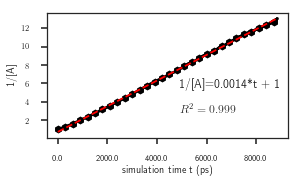

In [108]:
slope, intercept, r_value, p_value, std_err = stats.linregress(tA[:, 0], 1/(tA[:, 2]/2000.0))
print(slope, intercept)
popt, pcov = curve_fit(fx, tA[:, 0], (1/(tA[:, 2]/2000.0)))
ydata = (1/(tA[:, 2]/2000.0))
residuals = (1/(tA[:, 2]/2000.0)) - fx(tA[:, 0], popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
print(popt, r_squared)

plt.rcParams['figure.figsize'] = figsize(0.9)
plt.plot(tA[:, 0], 1/(tA[:, 2]/2000.0), linestyle='-', label='A', color='k', marker='h', markevery=300, markersize=8.0)
plt.plot(tA[:, 0], slope*tA[:, 0]+intercept, '--', color='r', linewidth=1.8)
plt.annotate('1/[A]={:.4f}*t + 1'.format(slope), xy=(0.55, 0.4), xycoords='axes fraction',fontsize=12)
plt.annotate(r'$R^2 = {:.3f}$'.format(r_squared), xy=(0.55, 0.2), xycoords='axes fraction',fontsize=12)
plt.ylabel('1/[A]')
plt.xlabel('simulation time t (ps)')
plt.xticks(np.arange(tA[:, 0][0], tA[:, 0][-1], 2000), np.arange(tA[:, 0][0], tA[:, 0][-1], 2000) - 500.0)

plt.tight_layout()
plt.savefig('result_graphics/no_water_reaction_order.pdf', dpi=200, tight_layout=True)

# Water

In [154]:
states_water = collections.defaultdict(dict)
t2name = {'t0': 'D', 't1': 'A', 't3': 'C', 't4': 'E', 't5': 'W'}
path = 'scan_p_1000/with_water/'
for f in os.listdir(path):
    if f.startswith('states_'):
        p = f.split('_')[3]
        t = t2name[f.split('_')[1]]
        d = np.loadtxt(os.path.join(path, f))
        #d.dtype = [(x, np.float) for x in open(os.path.join(path, f)).readline().replace('# ', '').split()]
        if t not in states_water[p]:
            states_water[p][t] = []
        states_water[p][t].append(d)
        #nb_no_water[p][t].dtype = [(x, np.float) for x in open(os.path.join(path, f)).readline().replace('# ', '').split()]

In [155]:
avg_states_water = collections.defaultdict(dict)
std_states_water = collections.defaultdict(dict)

max_states = {'A': 3, 'C': 3, 'E': 3, 'D': 3, 'W': 3}
column = {'D': 3, 'A': 2, 'C': 1, 'E': 2, 'W': 1}

for p, p_ts in states_water.items():
    for t, l in p_ts.items():
        max_length = min([len(k) for k in l])
        max_first_nonzero = 0
        tmp_l = []
        for ll in l:
            dll = np.diff(ll[:, column[t]])
            first_nonzero = np.nonzero(dll)[0][0]
            if first_nonzero > max_first_nonzero:
                max_first_nonzero = first_nonzero
        for ll in l:
            tmp_l.append(ll[first_nonzero:max_length])
        av = np.average(tmp_l, axis=0)
        avg_states_water[p][t] = av
        std_states_water[p][t] = np.std(tmp_l, axis=0)

In [156]:
states_water.keys()

dict_keys(['0.001', '0.0005', '0.005'])

In [157]:
cr = '0.001'
tD = avg_states_water[cr]['D']
tA = avg_states_water[cr]['A']
tC = avg_states_water[cr]['C']
tE = avg_states_water[cr]['E']
tW = avg_states_water[cr]['W']

def f_de(y, t, k):
    # print t, nbD[:, 0]
    cD   = y[0]
    cEs1 = y[1]
    cEs0 = y[2]
    #k = 0.6*k
    kcD   = k
    kcEs1 = k
    kcEs0 = k
    
    dcDdt = -kcD*cD
    dcEs1dt = -kcEs1*cEs1 + kcD*cD
    dcEs0dt = kcEs1*cEs1
    
    return np.array([dcDdt, dcEs1dt, dcEs0dt])

t0 = np.linspace(50, tE[:, 0][-1], 100)

y0 = np.array([1.0, 0.0, 0.0])
y = odeint(f_de, y0, t0, args=(float(cr), ))

def f_ac(y, t, k):
    a = y[0]
    c = y[1]
    k = k
    dadt = -k*a**2.0
    dcdt = k*a**2.0
    
    return np.array([dadt, dcdt])

t0 = np.linspace(52, tE[:, 0][-1], 100)
y_ac = odeint(f_ac, np.array([1.0, 0.0]), t0, args=(1.63466261542*float(cr),))
y_ac_raw = odeint(f_ac, np.array([1.0, 0.0]), t0, args=(float(cr),))

/home/teodor/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


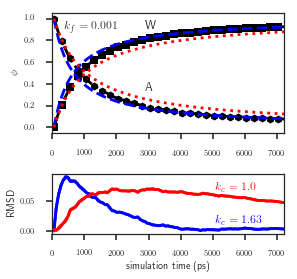

In [158]:
plt.rcParams['figure.figsize'] = figsize(0.9, height_ratio=1.5)
f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 1]})

a0.plot(tA[:, 0], tA[:, 2]/2000.0, '-.', label='A', color='k', marker='h', markevery=250, markersize=8.0)
a0.plot(tW[:, 0], tW[:, 1]/2000.0, '-.', label='W', color='k', marker='s', markevery=250, markersize=8.0)
a0.plot(t0, y_ac[:, 0], linestyle='--', color='b')
a0.plot(t0, y_ac[:, 1], linestyle='--', color='b')
a0.plot(t0, y_ac_raw[:, 0], color='r', linestyle=':')
a0.plot(t0, y_ac_raw[:, 1], color='r', linestyle=':')
a0.annotate(r'$k_f={}$'.format(cr), xy=(0.05, 0.85), xycoords='axes fraction', fontsize=12)
a0.annotate('W', xy=(0.4, 0.87), xycoords='axes fraction', fontsize=12)
a0.annotate('A', xy=(0.4, 0.35), xycoords='axes fraction', fontsize=12)

a0.set_ylabel(r'$\phi$')
a0.set_xlim([0, tE[:, 0][-1]])

#a0.legend(loc=0)

fA = interp1d(tA[:, 0], tA[:, 2]/2000.0)
fW = interp1d(tW[:, 0], tW[:, 1]/2000.0)
a1.plot(t0, np.sqrt(np.power(fA(t0) - y_ac[:, 0], 2)), color='b')
a1.plot(t0, np.sqrt(np.power(fW(t0) - y_ac[:, 1], 2)), color='b')
a1.plot(t0, np.sqrt(np.power(fA(t0) - y_ac_raw[:, 0], 2)), '-', color='r')
a1.plot(t0, np.sqrt(np.power(fW(t0) - y_ac_raw[:, 1], 2)), '-', color='r')
a1.annotate(r'$k_c=1.0$', xy=(0.7, 0.7), xycoords='axes fraction',fontsize=12, color='r')
a1.annotate(r'$k_c=1.63$', xy=(0.7, 0.15), xycoords='axes fraction',fontsize=12, color='b')
a1.legend(loc=0)
a1.set_xlim([0, tE[:, 0][-1]])
a1.set_xlabel('simulation time (ps)')
a1.set_ylabel('RMSD')

f.tight_layout()
f.savefig('result_graphics/conversions_water_{}.pdf'.format(str(cr).replace('.', '_')), dpi=200, tight_layout=True)

## Find the order

0.00178308865521 0.284305847308
[ 0.00163466] 0.940344982309


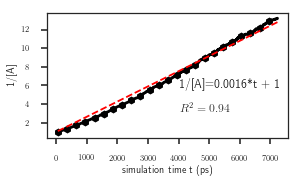

In [53]:
xdata = tA[:, 0]
ydata = (1/(tA[:, 2]/2000.0))
slope, intercept, r_value, p_value, std_err = stats.linregress(xdata, ydata)
print(slope, intercept)
popt, pcov = curve_fit(fx, xdata, ydata-1)
residuals = ydata - fx(xdata, popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((ydata-np.mean(ydata))**2)
r_squared = 1 - (ss_res / ss_tot)
print(popt, r_squared)

plt.rcParams['figure.figsize'] = figsize(0.9)
plt.plot(tA[:, 0], 1/(tA[:, 2]/2000.0), linestyle='-', label='A', color='k', marker='h', markevery=300, markersize=8.0)
plt.plot(tA[:, 0], popt[0]*tA[:, 0]+1, '--', color='r', linewidth=1.8)
plt.annotate('1/[A]={:.4f}*t + 1'.format(popt[0]), xy=(0.55, 0.4), xycoords='axes fraction',fontsize=12)
plt.annotate(r'$R^2 = {:.2f}$'.format(r_squared), xy=(0.55, 0.2), xycoords='axes fraction',fontsize=12)
plt.ylabel('1/[A]')
plt.xlabel('simulation time t (ps)')

plt.tight_layout()
plt.savefig('result_graphics/water_reaction_order.pdf', dpi=200, tight_layout=True)

# Water, reverse reaction

In [159]:
states_water_rev = collections.defaultdict(dict)
nb_water_rev = collections.defaultdict(dict)
t2name = {'t0': 'D', 't1': 'A', 't3': 'C', 't4': 'E', 't5': 'W'}
path = 'scan_p_1000/with_water_rev/'
for f in sorted(os.listdir(path)):
    if f.startswith('states_'):
        p = f.split('_')[3]
        t = t2name[f.split('_')[1]]
        d = np.loadtxt(os.path.join(path, f))
        #d.dtype = header = [(x, np.float) for x in open(os.path.join(path, f)).readline().replace('# ', '').split()]
        if t not in states_water_rev[p]:
            states_water_rev[p][t] = []
        states_water_rev[p][t].append(d)

In [160]:
avg_states_water_rev = collections.defaultdict(dict)
std_states_water_rev = collections.defaultdict(dict)
max_states = {'A': 3, 'C': 3, 'E': 3, 'D': 3, 'W': 3}
column = {'D': 3, 'A': 2, 'C': 1, 'E': 2, 'W': 1}

for p, p_ts in states_water_rev.items():
    for t, l in p_ts.items():
        max_length = min([len(k) for k in l])
        max_first_nonzero = 0
        tmp_l = []
        for ll in l:
            dll = np.diff(ll[:, column[t]])
            first_nonzero = np.nonzero(dll)[0][0]
            if first_nonzero > max_first_nonzero:
                max_first_nonzero = first_nonzero
        for ll in l:
            tmp_l.append(ll[first_nonzero:max_length])
        av = np.average(tmp_l, axis=0)
        avg_states_water_rev[p][t] = av
        std_states_water_rev[p][t] = np.std(tmp_l, axis=0)

In [161]:
def f_de(y, t, k):
    # print t, nbD[:, 0]
    cA   = y[0]
    cD   = y[1]
    cEs1 = y[2]
    cEs0 = y[3]
    cW   = y[4]
    
    dcAdt = -k*cA*cD + k*cW
    dcDdt = -k*cD*cA + k*cEs1
    dcEs1dt = -k*cEs1 + k*cD
    dcEs0dt = k*cEs1 - k*cW
    dcWdt = k*cA**2 - k*cW
    
    return np.array([dcAdt, dcDdt, dcEs1dt, dcEs0dt, dcWdt])

t0 = np.linspace(0, tE[:, 0][-1], 100)
y0 = np.array([1.0, 1.0, 0.0, 0.0, 0.0])
y = odeint(f_de, y0, t0, args=(float(cr),))

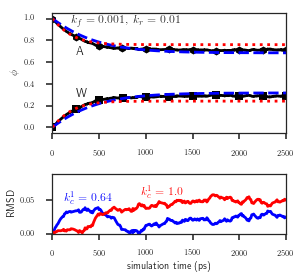

In [162]:
cr = '0.001'
tD = avg_states_water_rev[cr]['D']
tA = avg_states_water_rev[cr]['A']
tC = avg_states_water_rev[cr]['C']
tE = avg_states_water_rev[cr]['E']
tW = avg_states_water_rev[cr]['W']

def f_ac(y, t, k, kW):
    a = y[0]
    c = y[1]
    w = y[2]
#     k *= 2.0
#     kW *= 2.0
    dcdt = k*a**2 - kW*(w**2)
    dadt = -k*a**2 + kW*(w**2)
    dwdt = k*a**2 - kW*(w**2)
    
    return np.array([dadt, dcdt, dwdt])

plt.rcParams['figure.figsize'] = figsize(0.9, height_ratio=1.5)
f, (a0, a0e) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 1]})

# plt.subplot(131)
kc1 = 1.0
kc2 = 0.64
kc3 = 0.3
t0 = np.linspace(0, tA[:, 0][-1], 500)
y_ac = odeint(f_ac, np.array([1.0, 0.0, 0.0]), t0, args=(0.64*float(cr), kc3*0.01))
y_ac_raw = odeint(f_ac, np.array([1.0, 0.0, 0.0]), t0, args=(kc1*float(cr), 0.01))

a0.plot(tA[:, 0], tA[:, 2]/2000.0, '-', label='A', color='k', marker='h', markevery=250, markersize=8.0)
a0.plot(tW[:, 0], tW[:, 1]/2000.0, '-', label='W', color='k', marker='s', markevery=250, markersize=8.0)
a0.plot(t0, y_ac[:, 0], color='b', linestyle='--')
a0.plot(t0, y_ac[:, 2], color='b', linestyle='--')
a0.plot(t0, y_ac_raw[:, 0], color='r', linestyle=':')
a0.plot(t0, y_ac_raw[:, 2], color='r', linestyle=':')
a0.annotate(r'$k_f={}, \; k_r=0.01$'.format(cr), xy=(0.08, 0.9), xycoords='axes fraction', fontsize=12)
a0.annotate('A', xy=(0.1, 0.65), xycoords='axes fraction', fontsize=12)
a0.annotate('W', xy=(0.1, 0.3), xycoords='axes fraction', fontsize=12)

a0.set_ylabel(r'$\phi$')
a0.set_xlim([0, 2500])
#a0.legend(loc=4)

# RMSE
fA = interp1d(tA[:, 0], tA[:, 2]/2000.0)
a0e.plot(t0, np.sqrt(np.power(fA(t0) - y_ac[:, 0], 2)), color='b')
a0e.plot(t0, np.sqrt(np.power(fA(t0) - y_ac_raw[:, 0], 2)), '-', color='r')
a0e.annotate(r'$k^1_c={}$'.format(kc1), xy=(0.38, 0.6), xycoords='axes fraction', fontsize=12, color='r')
a0e.annotate(r'$k^1_c={}$'.format(kc2), xy=(0.05, 0.5), xycoords='axes fraction', fontsize=12, color='b')
#a0e.legend(loc=0)
a0e.set_xlim([0, 2500])
a0e.set_ylim([0, 0.09])
a0e.set_xlabel('simulation time (ps)')
a0e.set_ylabel('RMSD')

f.tight_layout()
f.tight_layout()
f.savefig('result_graphics/conversions_water_rev_{}.pdf'.format(str(cr).replace('.', '_')), dpi=200, tight_layout=True)

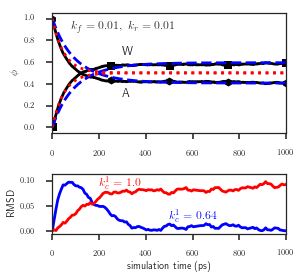

In [163]:
cr = '0.01'
tD = avg_states_water_rev[cr]['D']
tA = avg_states_water_rev[cr]['A']
tC = avg_states_water_rev[cr]['C']
tE = avg_states_water_rev[cr]['E']
tW = avg_states_water_rev[cr]['W']

def f_ac(y, t, k, kW):
    a = y[0]
    c = y[1]
    w = y[2]
#     k *= 2.0
#     kW *= 2.0
    dcdt = k*a**2 - kW*(w**2)
    dadt = -k*a**2 + kW*(w**2)
    dwdt = k*a**2 - kW*(w**2)
    
    return np.array([dadt, dcdt, dwdt])

plt.rcParams['figure.figsize'] = figsize(0.9, height_ratio=1.5)
f, (a0, a0e) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 1]})

# plt.subplot(131)
kc1 = 1.0
kc2 = 0.64
kc3 = 0.3
t0 = np.linspace(0, tA[:, 0][-1], 500)
y_ac = odeint(f_ac, np.array([1.0, 0.0, 0.0]), t0, args=(0.64*float(cr), kc3*0.01))
y_ac_raw = odeint(f_ac, np.array([1.0, 0.0, 0.0]), t0, args=(kc1*float(cr), 0.01))

a0.plot(tA[:, 0], tA[:, 2]/2000.0, '-', label='A', color='k', marker='h', markevery=250, markersize=8.0)
a0.plot(tW[:, 0], tW[:, 1]/2000.0, '-', label='W', color='k', marker='s', markevery=250, markersize=8.0)
a0.plot(t0, y_ac[:, 0], color='b', linestyle='--')
a0.plot(t0, y_ac[:, 2], color='b', linestyle='--')
a0.plot(t0, y_ac_raw[:, 0], color='r', linestyle=':')
a0.plot(t0, y_ac_raw[:, 2], color='r', linestyle=':')
a0.annotate(r'$k_f={}, \; k_r=0.01$'.format(cr), xy=(0.08, 0.85), xycoords='axes fraction', fontsize=12)
a0.annotate('W', xy=(0.3, 0.65), xycoords='axes fraction', fontsize=12)
a0.annotate('A', xy=(0.3, 0.3), xycoords='axes fraction', fontsize=12)

a0.set_ylabel(r'$\phi$')
a0.set_xlim([0, 1000])
#a0.legend(loc=4)

# RMSE
fA = interp1d(tA[:, 0], tA[:, 2]/2000.0)
a0e.plot(t0, np.sqrt(np.power(fA(t0) - y_ac[:, 0], 2)), color='b')
a0e.plot(t0, np.sqrt(np.power(fA(t0) - y_ac_raw[:, 0], 2)), '-', color='r')
a0e.annotate(r'$k^1_c={}$'.format(kc1), xy=(0.2, 0.75), xycoords='axes fraction', fontsize=12, color='r')
a0e.annotate(r'$k^1_c={}$'.format(kc2), xy=(0.5, 0.2), xycoords='axes fraction', fontsize=12, color='b')
#a0e.legend(loc=0)
a0e.set_xlim([0, 1000])
a0e.set_xlabel('simulation time (ps)')
a0e.set_ylabel('RMSD')

f.tight_layout()
f.tight_layout()
f.savefig('result_graphics/conversions_water_rev_{}.pdf'.format(str(cr).replace('.', '_')), dpi=200, tight_layout=True)

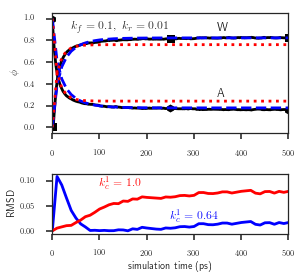

In [164]:
cr = '0.1'
tD = avg_states_water_rev[cr]['D']
tA = avg_states_water_rev[cr]['A']
tC = avg_states_water_rev[cr]['C']
tE = avg_states_water_rev[cr]['E']
tW = avg_states_water_rev[cr]['W']

def f_ac(y, t, k, kW):
    a = y[0]
    c = y[1]
    w = y[2]
#     k *= 2.0
#     kW *= 2.0
    dcdt = k*a**2 - kW*(w**2)
    dadt = -k*a**2 + kW*(w**2)
    dwdt = k*a**2 - kW*(w**2)
    
    return np.array([dadt, dcdt, dwdt])

plt.rcParams['figure.figsize'] = figsize(0.9, height_ratio=1.5)
f, (a0, a0e) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[2, 1]})

# plt.subplot(131)
kc1 = 1.0
kc2 = 0.64
kc3 = 0.3
t0 = np.linspace(0, tA[:, 0][-1], 500)
y_ac = odeint(f_ac, np.array([1.0, 0.0, 0.0]), t0, args=(0.64*float(cr), kc3*0.01))
y_ac_raw = odeint(f_ac, np.array([1.0, 0.0, 0.0]), t0, args=(kc1*float(cr), 0.01))

a0.plot(tA[:, 0], tA[:, 2]/2000.0, '-', label='A', color='k', marker='h', markevery=250, markersize=8.0)
a0.plot(tW[:, 0], tW[:, 1]/2000.0, '-', label='W', color='k', marker='s', markevery=250, markersize=8.0)
a0.plot(t0, y_ac[:, 0], color='b', linestyle='--')
a0.plot(t0, y_ac[:, 2], color='b', linestyle='--')
a0.plot(t0, y_ac_raw[:, 0], color='r', linestyle=':')
a0.plot(t0, y_ac_raw[:, 2], color='r', linestyle=':')
a0.annotate(r'$k_f={}, \; k_r=0.01$'.format(cr), xy=(0.08, 0.85), xycoords='axes fraction', fontsize=12)
a0.annotate('W', xy=(0.7, 0.85), xycoords='axes fraction', fontsize=12)
a0.annotate('A', xy=(0.7, 0.3), xycoords='axes fraction', fontsize=12)

a0.set_ylabel(r'$\phi$')
a0.set_xlim([0, 500])
#a0.legend(loc=4)

# RMSE
fA = interp1d(tA[:, 0], tA[:, 2]/2000.0)
a0e.plot(t0, np.sqrt(np.power(fA(t0) - y_ac[:, 0], 2)), color='b')
a0e.plot(t0, np.sqrt(np.power(fA(t0) - y_ac_raw[:, 0], 2)), '-', color='r')
a0e.annotate(r'$k^1_c={}$'.format(kc1), xy=(0.2, 0.75), xycoords='axes fraction', fontsize=12, color='r')
a0e.annotate(r'$k^1_c={}$'.format(kc2), xy=(0.5, 0.2), xycoords='axes fraction', fontsize=12, color='b')
#a0e.legend(loc=0)
a0e.set_xlim([0, 500])
a0e.set_xlabel('simulation time (ps)')
a0e.set_ylabel('RMSD')

f.tight_layout()
f.tight_layout()
f.savefig('result_graphics/conversions_water_rev_{}.pdf'.format(str(cr).replace('.', '_')), dpi=200, tight_layout=True)